In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
from os import path
import xarray as xr
from matplotlib.colors import Normalize, LinearSegmentedColormap
import matplotlib.colors as colors
import scipy.stats as stats
from netCDF4 import Dataset
from scipy.stats import pearsonr
import wrf
import sys
sys.path.append('/glade/u/home/hawbecke/Code/Python/')
from pydicts.obsdict import get_FINO_obs
from mmctools.mmctools.plotting import TaylorDiagram
from mmctools.mmctools.helper_functions import theta_to_T, lowess_mean, calc_uv, calc_wind, w_s, T_d
from mmctools.mmctools.wrf.utils import Tower, tsout_seriesReader, write_tslist_file
from pydicts.baybreezedict import DetectBayBreeze
import matplotlib.gridspec as gridspec
from string import ascii_lowercase
import matplotlib.patches as patches

# Where to save the images:

In [2]:
save_dir = '/glade/work/hawbecke/ATEC/Chesapeake/SENSITIVITY_STUDY/20190716to20190801/img/'

# WRF Data location:

In [3]:
wrf_dir    = '/glade/scratch/hawbecke/WRF/ATEC/Chesapeake/20190716to20190801/'
work_dir   = '/glade/work/hawbecke/ATEC/Chesapeake/SENSITIVITY_STUDY/20190716to20190801/'

restarts   = ['CBB_2019071518', 'CBB_2019071718', 'CBB_2019071918', 'CBB_2019072118', 
              'CBB_2019072318', 'CBB_2019072518', 'CBB_2019072718', 'CBB_2019072918']

wrf_start  = ['2019-07-15 18:00:00','2019-07-17 18:00:00','2019-07-19 18:00:00','2019-07-21 18:00:00',
              '2019-07-23 18:00:00','2019-07-25 18:00:00','2019-07-27 18:00:00','2019-07-29 18:00:00',]

sys.path.append('/glade/u/home/hawbecke/Code/Python/publications/Chesapeake')

from CBB_case_dict import case_dict
cases = list(case_dict.keys())

ncases   = len(cases)
case_dom = [3]*ncases

# Tower data:

In [4]:
obs_dir = '/glade/work/hawbecke/ATEC/Chesapeake/Data/Obs/'
awos_ds = xr.open_dataset('{}AWOS/AWOS_2019to2020.nc'.format(obs_dir))
asos_ds = xr.open_dataset('{}ASOS/ASOS_2019to2020.nc'.format(obs_dir))
apg_ds  = xr.open_dataset('{}APG/APG_data_2019.nc'.format(obs_dir))

In [5]:
near_shore_stations  = []
inland_station_names = []
for stn in awos_ds.get_index('station'):
    if awos_ds.sel(station=stn).region.data == 'inland':
        inland_station_names.append(stn)
    if awos_ds.sel(station=stn).region.data == 'coastal':
        near_shore_stations.append(stn)
for stn in asos_ds.get_index('station'):
    if asos_ds.sel(station=stn).region.data == 'inland':
        inland_station_names.append(stn)
    if asos_ds.sel(station=stn).region.data == 'coastal':
        near_shore_stations.append(stn)
for stn in apg_ds.get_index('station'):
    near_shore_stations.append(stn)

near_shore_stations = np.unique(near_shore_stations)
inland_station_names = np.unique(inland_station_names)

In [6]:
ref_stn = 'IAD'
wrf_twrs = {}
for cc,case in enumerate(cases):
    dom = case_dom[cc]
    case_str = '{}_{}'.format(case,'d0{}'.format(dom))
    if dom == 3:
        dt = 9.0
    elif dom == 4:
        dt = 3.0
    else:
        print('Add logic for domain {}'.format(dom))
    print('Starting {} d0{}: time step = {}'.format(case_str,dom,dt))
    

    case_dir = '{}{}/'.format(work_dir,case)
    twr_path = '{}{}_d0{}_towers.nc'.format(case_dir,case,dom)    
    if path.exists(twr_path):
        print('loading in full dataset!')
        wrf_twrs[case_str] = xr.open_dataset(twr_path)
    else:
        case_dir = '{}{}/'.format(wrf_dir,case)

        wrf_twrs[case_str] = tsout_seriesReader(case_dir,restarts,wrf_start,'d0{}'.format(dom),structure='unordered',
                                            select_tower=np.append(near_shore_stations,ref_stn),time_step=dt,
                                            #select_tower=near_shore_stations[:2],time_step=dt,
                                            heights=[10.0],height_var='ph')
        wrf_twrs[case_str]['temp'] = theta_to_T(wrf_twrs[case_str].theta,wrf_twrs[case_str].pr/100.0)-273.15
        wrf_twrs[case_str]['wspd10'],wrf_twrs[case_str]['wdir10'] = calc_wind(wrf_twrs[case_str],u='u10',v='v10')
        wrf_twrs[case_str]['t2'] += -273.15 
        wrf_twrs[case_str].to_netcdf(twr_path)

Starting GFSR_YSU_CHRN_GFS_NOSK_3DOM_d03 d03: time step = 9.0
loading in full dataset!
Starting GFSR_YSU_CHRN_GFS_SKNT_3DOM_d03 d03: time step = 9.0
loading in full dataset!
Starting GFSR_YSU_CHRN_GHR_NOSK_3DOM_d03 d03: time step = 9.0
loading in full dataset!
Starting GFSR_YSU_CHRN_GHR_SKNT_3DOM_d03 d03: time step = 9.0
loading in full dataset!
Starting GFSR_YSU_CHRN_MOD_NOSK_3DOM_d03 d03: time step = 9.0
loading in full dataset!
Starting GFSR_YSU_CHRN_MOD_SKNT_3DOM_d03 d03: time step = 9.0
loading in full dataset!
Starting ERAI_YSU_CHRN_OST_NOSK_4DOM_d03 d03: time step = 9.0
loading in full dataset!
Starting ERAI_YSU_CHRN_OST_SKNT_3DOM_d03 d03: time step = 9.0
loading in full dataset!
Starting ERAI_YSU_CHRN_GHR_NOSK_3DOM_d03 d03: time step = 9.0
loading in full dataset!
Starting ERAI_YSU_CHRN_GHR_SKNT_3DOM_d03 d03: time step = 9.0
loading in full dataset!
Starting ERAI_YSU_CHRN_MOD_NOSK_3DOM_d03 d03: time step = 9.0
loading in full dataset!
Starting ERAI_YSU_CHRN_MOD_SKNT_3DOM_d03 d0

In [7]:
t_s = wrf_twrs['{}_{}'.format(cases[0],'d0{}'.format(case_dom[0]))].datetime.data[0] + pd.to_timedelta(12,'h') - pd.to_timedelta(9,'s') # Account for spinup
t_e = wrf_twrs['{}_{}'.format(cases[0],'d0{}'.format(case_dom[0]))].datetime.data[-1]

# Many stations are missing data - these are the good ones:
near_shore_stations = ['APG', 'BWI', 'MTN', 'NAK', 'NHK', 'NUI']

vars_to_compare = {'temp':'t2'}

In [8]:
for ss,stn in enumerate(near_shore_stations):
    if stn in asos_ds.get_index('station'):
        twr_ds = asos_ds.sel(station=stn)
    elif stn in awos_ds.get_index('station'):
        twr_ds = awos_ds.sel(station=stn)
    #elif stn in apg_ds.get_index('station'):
    #    twr_ds = apg_ds.sel(station=stn)
    else:
        print('no obs for this station: {}'.format(stn))
    if stn == 'APG':
        twr_ds = apg_ds.sel(station='PAA')
        twr_ds.station.data = 'APG'

    twr_res = twr_ds.copy().sel(datetime=slice(t_s,t_e))
    for dd in twr_res.data_vars:
        if dd not in vars_to_compare:
            twr_res = twr_res.drop_vars(dd)
    twr_res = twr_res.resample(datetime='5min').nearest(tolerance='5min')
    if ss == 0:
        twr_res_full = twr_res
    else:
        twr_res_full = xr.concat([twr_res_full,twr_res],dim='station')

In [9]:
def resample_model_output(stn_ds,twr_ds,var_dict,adjustments=None,select_stations=None):
    for vv,var in enumerate(var_dict):
        obs_var = var
        stn_var = var_dict[var]

        temp_ds = stn_ds.copy()
        temp_ds.drop_vars(stn_var)
        temp_var = stn_ds[stn_var].copy()
        if adjustments is not None and len(adjustments) == len(var_dict):
            adjustment = adjustments[vv]
            if adjustment is not None:
                print('Adjusting {} by {}'.format(var,adjustment))
                if adjustment[0] == '+' or adjustment[0] == '-':
                    temp_var += float(adjustment)
                elif adjustment[0] == '*':
                    temp_var = temp_var*float(adjustment[1:])
                elif adjustment[0] == '/':
                    temp_var = temp_var/float(adjustment[1:])
                else:
                    print('adjustment {} not understood. Please use +, -, *, or /'.format(adjustments))
        if select_stations is not None:
            station_list = select_stations
        else:
            station_list = stn_ds.station.data
        for ss,stn in enumerate(station_list):
            if type(twr_ds) == dict:
                obs = twr_ds[stn]
            elif type(twr_ds) == xr.core.dataset.Dataset:
                obs = twr_ds.sel(station=stn)
            else:
                'Need to figure out data type of twr_ds'
            var = temp_var.sel(station=stn)
            
            var[np.where(np.isnan(obs[obs_var].data))] = var[np.where(np.isnan(obs[obs_var].data))]*np.nan

            temp_var.sel(station=stn).data = var.data

        stn_ds[stn_var] = temp_var
    return(stn_ds)

In [10]:
wrf_twrs_res = {}
for cc,case in enumerate(wrf_twrs):        
    wrf_twrs_res[case] = resample_model_output(wrf_twrs[case].copy().sel(datetime=slice(t_s,t_e)).resample(
                                               datetime='5min').nearest(tolerance='5min'),
                                               twr_res_full,var_dict=vars_to_compare,
                                               select_stations=near_shore_stations)

# Buoy Data

In [11]:
obs_f_dir = '/glade/work/hawbecke/ATEC/Chesapeake/Data/Obs/BUOY/'
obs_type = 'combined' # combined or CBIBS or NDBC
#obs_dir = '{}{}/'.format(obs_f_dir,obs_type)
buoy_f = '{}{}_buoy_data_res_2019.nc'.format(obs_f_dir,obs_type)
buoy_ds = xr.open_dataset(buoy_f)

In [12]:
buoy_loc_dict = {}
for stn in buoy_ds.station.data:
    buoy_loc_dict[stn] = {'lat':float(buoy_ds.sel(station=stn).lat.data),
                     'lon':float(buoy_ds.sel(station=stn).lon.data)}

buoy_list = list(buoy_loc_dict.keys())

buoy_loc_dict['JTN']['lat'] = 37.21137
buoy_loc_dict['JTN']['lon'] = -76.78677

bad_buoys = ['PMC','GRF','SRP','CAM','SLM','WDC']

for bad_buoy in bad_buoys:
    buoy_list.remove(bad_buoy)

buoy_ds.lat.loc[{'station':'JTN'}] = 37.21137
buoy_ds.lon.loc[{'station':'JTN'}] = -76.78677

In [13]:
wrf_buoys = {}
for cc,case in enumerate(cases):
    new_f_name = '{0}{1}/{1}_extracted_{2}_buoy_data_d0{3}.nc'.format(work_dir,case,obs_type,case_dom[cc])
    if path.exists('{}'.format(new_f_name)):
        print('Data for {} already created!'.format(new_f_name.split('/')[-1]))
        wrf_buoys['{}_{}'.format(case,'d0{}'.format(case_dom[cc]))] = xr.open_dataset('{}'.format(new_f_name))
    else:
        print(case, new_f_name)
        get_wrf_locs = True
        rst_dict = {}
        for rr,rst in enumerate(restarts):
            print('starting {}'.format(rst))
            f_list = sorted(glob.glob('{}{}/{}/wrfout_d0{}*'.format(wrf_dir,case,rst,case_dom[cc])))

            if get_wrf_locs:
                wrf_loc_dict = {}
                wrf_i = Dataset('{}/wrfinput_d0{}'.format('/'.join(f_list[0].split('/')[:-1]),case_dom[cc]))
                is_water = [True]*len(buoy_loc_dict)
                hgt      = np.zeros(len(buoy_loc_dict))
                for ss,stn in enumerate(buoy_loc_dict):
                    wrf_loc_dict[stn] = {}
                    loc_x,loc_y = wrf.ll_to_xy(wrf_i,buoy_loc_dict[stn]['lat'],buoy_loc_dict[stn]['lon'])
                    loc_x = int(loc_x.data)
                    loc_y = int(loc_y.data)
                    # Some buoy locations are on land... grab the water cell next to it
                    if obs_type == 'CBIBS':
                        if stn == 'ANN':loc_x += 1
                    elif (obs_type == 'NDBC') or (obs_type == 'combined'):
                        if stn == 'CAM':loc_y += 1
                        if stn == 'SLM':loc_x += 1


                    #print(loc_x,loc_y)
                    wrf_loc_dict[stn]['x'] = loc_x
                    wrf_loc_dict[stn]['y'] = loc_y
                    #print(wrf_loc_dict[stn])
                    # Check WRF is grabbing right locations:
                    wrf_lat = wrf_i.variables['XLAT'][0,loc_y,loc_x]
                    wrf_lon = wrf_i.variables['XLONG'][0,loc_y,loc_x]
                    landmask = wrf_i.variables['LANDMASK'][0,loc_y,loc_x]
                    hgt[ss]  = wrf_i.variables['HGT'][0,loc_y,loc_x]
                    if landmask == 1:
                        is_water[ss] = False
                get_wrf_locs = False
                wrf_i.close()
            wrf_times = []

            wspd = np.zeros((len(f_list),len(buoy_loc_dict)))
            wdir = np.zeros((len(f_list),len(buoy_loc_dict)))
            t2   = np.zeros((len(f_list),len(buoy_loc_dict)))
            tsk  = np.zeros((len(f_list),len(buoy_loc_dict)))
            pres = np.zeros((len(f_list),len(buoy_loc_dict)))
            dwpt = np.zeros((len(f_list),len(buoy_loc_dict)))
            sst  = np.zeros((len(f_list),len(buoy_loc_dict)))
            

            for ff,fname in enumerate(f_list):
                wrf_f = Dataset(fname)
                wrf_times.append(wrf.extract_times(wrf_f,timeidx=0))
                for ss,stn in enumerate(buoy_loc_dict):
                    u10 = wrf_f.variables['U10'][0,wrf_loc_dict[stn]['y'],wrf_loc_dict[stn]['x']]
                    v10 = wrf_f.variables['V10'][0,wrf_loc_dict[stn]['y'],wrf_loc_dict[stn]['x']]

                    wspd[ff,ss] = (u10**2 + v10**2)**0.5
                    wdir[ff,ss] = 180. + np.degrees(np.arctan2(u10, v10))
                    t2[ff,ss]   = wrf_f.variables['T2'][0,wrf_loc_dict[stn]['y'],wrf_loc_dict[stn]['x']]
                    tsk[ff,ss]  = wrf_f.variables['TSK'][0,wrf_loc_dict[stn]['y'],wrf_loc_dict[stn]['x']]
                    pres[ff,ss] = wrf_f.variables['PSFC'][0,wrf_loc_dict[stn]['y'],wrf_loc_dict[stn]['x']]/100.0
                    mixingratio = wrf_f.variables['Q2'][0,wrf_loc_dict[stn]['y'],wrf_loc_dict[stn]['x']]
                    w_sat       = w_s(t2[ff,ss],pres[ff,ss])
                    rh          = (mixingratio/w_sat)*100.0
                    dwpt[ff,ss] = T_d(t2[ff,ss],rh,celsius=True)
                    
                    try:
                        sst[ff,ss]  = wrf_f.variables['SST'][0,wrf_loc_dict[stn]['y'],wrf_loc_dict[stn]['x']]
                    except KeyError:
                        if ff == 0 and ss == 0: print('no SST data found... setting to zero')
                        sst[ff,ss] = tsk[ff,ss]*0.0
                    

                wrf_f.close()
            rst_dict[rst] = xr.Dataset({'wspd': (['datetime','station'],wspd),
                                        'wdir': (['datetime','station'],wdir),
                                        't2'  : (['datetime','station'],t2),
                                        'tsk' : (['datetime','station'],tsk),
                                        'sst' : (['datetime','station'],sst),
                                        'pres': (['datetime','station'],pres),
                                        'dwpt': (['datetime','station'],dwpt),
                                    'is_water': (['station'],is_water),
                                         'hgt': (['station'],hgt)},
                                        coords={'datetime':wrf_times,
                                                'station': list(buoy_loc_dict.keys())})             
            if rr == 0:
                full_ds = rst_dict[rst]
            else:
                full_ds = full_ds.combine_first(rst_dict[rst])

        full_ds.to_netcdf(new_f_name)
        wrf_buoys['{}_{}'.format(case,'d0{}'.format(case_dom[cc]))]  = full_ds


        fig = plt.figure(figsize=(18,6))
        full_ds.sel(station='ANN').dwpt.plot(lw=2.0,c='k')
        for rr,rst in enumerate(rst_dict):
            rst_dict[rst].sel(station='ANN').dwpt.plot(lw=1.0)
        plt.show()
        


Data for GFSR_YSU_CHRN_GFS_NOSK_3DOM_extracted_combined_buoy_data_d03.nc already created!
Data for GFSR_YSU_CHRN_GFS_SKNT_3DOM_extracted_combined_buoy_data_d03.nc already created!
Data for GFSR_YSU_CHRN_GHR_NOSK_3DOM_extracted_combined_buoy_data_d03.nc already created!
Data for GFSR_YSU_CHRN_GHR_SKNT_3DOM_extracted_combined_buoy_data_d03.nc already created!
Data for GFSR_YSU_CHRN_MOD_NOSK_3DOM_extracted_combined_buoy_data_d03.nc already created!
Data for GFSR_YSU_CHRN_MOD_SKNT_3DOM_extracted_combined_buoy_data_d03.nc already created!
Data for ERAI_YSU_CHRN_OST_NOSK_4DOM_extracted_combined_buoy_data_d03.nc already created!
Data for ERAI_YSU_CHRN_OST_SKNT_3DOM_extracted_combined_buoy_data_d03.nc already created!
Data for ERAI_YSU_CHRN_GHR_NOSK_3DOM_extracted_combined_buoy_data_d03.nc already created!
Data for ERAI_YSU_CHRN_GHR_SKNT_3DOM_extracted_combined_buoy_data_d03.nc already created!
Data for ERAI_YSU_CHRN_MOD_NOSK_3DOM_extracted_combined_buoy_data_d03.nc already created!
Data for E

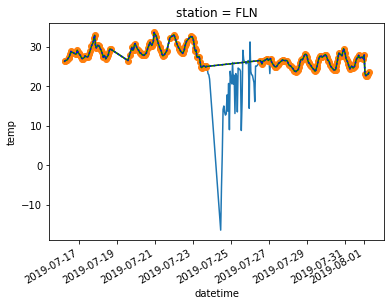

In [14]:
if 'FLN' in buoy_ds.station.data:
    temp_obs = buoy_ds.temp.copy()
    buoy_ds = buoy_ds.drop_vars('temp')

    fln = temp_obs.sel(station='FLN')
    fln.sel(datetime=slice(t_s,t_e)).dropna(how='all',dim='datetime').plot()

    rem_starts = ['2019-07-23 18:00:00','2019-07-27 00:00:00']
    rem_ends  = ['2019-07-26 12:00:00','2019-07-27 01:45:00']


    for rem_s,rem_e in zip(rem_starts,rem_ends):
        fln.sel(datetime=slice(rem_s,rem_e)).data[:] = fln.sel(datetime=slice(rem_s,rem_e)).data[:]*np.nan

    fln.sel(datetime=slice(t_s,t_e)).dropna(how='all',dim='datetime').plot(marker='o')

    temp_obs.sel(station='FLN').data = fln.data

    temp_obs.sel(station='FLN').sel(datetime=slice(t_s,t_e)).dropna(how='all',dim='datetime').plot(c='g')
    buoy_ds['temp'] = temp_obs

    buoy_ds.sel(station='FLN').sel(datetime=slice(t_s,t_e)).temp.dropna(how='all',dim='datetime').plot(c='b',ls=':')
    plt.show()

In [15]:
vars_to_compare = {'sst':'tsk'}
buoy_res = buoy_ds.copy().sel(datetime=slice(t_s,t_e))
buoy_res = buoy_res.resample(datetime='1h').nearest(tolerance='15m')

wrf_buoys_res = {}
for cc,case in enumerate(wrf_buoys):
    print(case)
    wrf_buoys_res[case] = resample_model_output(wrf_buoys[case].copy().sel(datetime=slice(t_s,t_e)),
                                                buoy_res,var_dict=vars_to_compare,
                                                adjustments=['-273.15','-273.15',None])#,None,None,None])
    

GFSR_YSU_CHRN_GFS_NOSK_3DOM_d03
GFSR_YSU_CHRN_GFS_SKNT_3DOM_d03
GFSR_YSU_CHRN_GHR_NOSK_3DOM_d03
GFSR_YSU_CHRN_GHR_SKNT_3DOM_d03
GFSR_YSU_CHRN_MOD_NOSK_3DOM_d03
GFSR_YSU_CHRN_MOD_SKNT_3DOM_d03
ERAI_YSU_CHRN_OST_NOSK_4DOM_d03
ERAI_YSU_CHRN_OST_SKNT_3DOM_d03
ERAI_YSU_CHRN_GHR_NOSK_3DOM_d03
ERAI_YSU_CHRN_GHR_SKNT_3DOM_d03
ERAI_YSU_CHRN_MOD_NOSK_3DOM_d03
ERAI_YSU_CHRN_MOD_SKNT_3DOM_d03
ERAI_YSU_CHRN_OST_OVER_3DOM_d03
ERAI_YSU_CHRN_OST_OVSK_3DOM_d03
ERA5_YSU_CHRN_ER5_NOSK_3DOM_d03
ERA5_YSU_CHRN_ER5_SKNT_3DOM_d03
ERA5_YSU_CHRN_ER5_OVER_3DOM_d03
ERA5_YSU_CHRN_ER5_OVSK_3DOM_d03


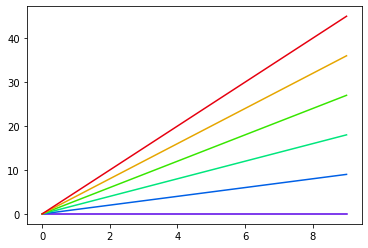

In [16]:
stn_colors = {}
for ss,stn in enumerate(near_shore_stations):
    line_cols = plt.cm.gist_rainbow_r(np.linspace(0.15,1.0,len(near_shore_stations)))[ss]
    darken = 0.1
    #line_cols = plt.cm.Set1_r(np.linspace(0.4,1.0,len(near_shore_stations)))[ss]
    for tt,col in enumerate(line_cols):
        if tt < 3:
            line_cols[tt] = col - darken
            if line_cols[tt] < 0.0: line_cols[tt] = 0.0
    stn_colors[stn] = line_cols
for ss,stn in enumerate(near_shore_stations):
    plt.plot(np.arange(0,10),np.arange(0,10)*ss,c=stn_colors[stn])
    


# Need to link inland stations with a buoy for ∆T

In [17]:
closest_buoy_dict = {}
for twr in near_shore_stations:
    twr_lat = twr_res_full.sel(station=twr).lat.data
    twr_lon = twr_res_full.sel(station=twr).lon.data
    
    closest_buoy_dict[twr] = {}
    closest_buoy_dist = 999.9
    for buoy in (buoy_list):
        buoy_lat = buoy_res.sel(station=buoy).lat.data
        buoy_lon = buoy_res.sel(station=buoy).lon.data
        dist_from_buoy = np.sqrt((twr_lat - buoy_lat)**2 + (twr_lon - buoy_lon)**2)
        if dist_from_buoy < closest_buoy_dist:
            closest_buoy_dist = dist_from_buoy
            closest_buoy = buoy
    closest_buoy_dict[twr] = {'buoy':closest_buoy,
                              'dist':closest_buoy_dist}
    

# Resample buoy to 5 minutes for buoys

In [18]:
buoy_res_full = buoy_res.resample(datetime='5min').nearest(tolerance='30min')

# Find ∆T between near shore station and closest buoy:

#### Obs

In [19]:
obs_delT = {}
for twr in near_shore_stations:
    closest_buoy = closest_buoy_dict[twr]['buoy']
    
    dT = twr_res_full.sel(station=twr).temp - buoy_res_full.sel(station=closest_buoy).sst
    
    obs_delT[twr] = {'delT':dT,
                     'temp':twr_res_full.sel(station=twr).temp,
                     'buoy':closest_buoy}


### Sim

In [20]:
sim_delT = {}
for cc,case in enumerate(cases):
    print(case)
    sim_delT['{}_d0{}'.format(case,case_dom[cc])] = {}
    for twr in near_shore_stations:
        wrf_twr = wrf_twrs_res['{0}_d{1:02d}'.format(case,case_dom[cc])]
        wrf_buoy = wrf_buoys_res['{0}_d{1:02d}'.format(case,case_dom[cc])]
        closest_buoy = closest_buoy_dict[twr]['buoy']
        wrf_stn_temp = wrf_twr.sel(station=twr).temp.resample(datetime='5min').nearest(tolerance='30min')
        wrf_buoy_sst = wrf_buoy.sel(station=closest_buoy).tsk.resample(datetime='5min').nearest(tolerance='30min')
        if np.nanmean(wrf_buoy_sst) > 100:
            wrf_buoy_sst += -273.15
                
        dT = wrf_stn_temp - wrf_buoy_sst
        sim_delT['{}_d0{}'.format(case,case_dom[cc])][twr] = {'delT':dT,
                                                              'temp':wrf_stn_temp,
                                                              'buoy':closest_buoy}
        

        

GFSR_YSU_CHRN_GFS_NOSK_3DOM
GFSR_YSU_CHRN_GFS_SKNT_3DOM
GFSR_YSU_CHRN_GHR_NOSK_3DOM
GFSR_YSU_CHRN_GHR_SKNT_3DOM
GFSR_YSU_CHRN_MOD_NOSK_3DOM
GFSR_YSU_CHRN_MOD_SKNT_3DOM
ERAI_YSU_CHRN_OST_NOSK_4DOM
ERAI_YSU_CHRN_OST_SKNT_3DOM
ERAI_YSU_CHRN_GHR_NOSK_3DOM
ERAI_YSU_CHRN_GHR_SKNT_3DOM
ERAI_YSU_CHRN_MOD_NOSK_3DOM
ERAI_YSU_CHRN_MOD_SKNT_3DOM
ERAI_YSU_CHRN_OST_OVER_3DOM
ERAI_YSU_CHRN_OST_OVSK_3DOM
ERA5_YSU_CHRN_ER5_NOSK_3DOM
ERA5_YSU_CHRN_ER5_SKNT_3DOM
ERA5_YSU_CHRN_ER5_OVER_3DOM
ERA5_YSU_CHRN_ER5_OVSK_3DOM


# Compare Results:

In [21]:
remove_mean = False

remove_night = True
night_hour_s = 22
night_hour_e = 12

remove_low_wspds = True
wspd_cutoff = 1.4

only_observed_bb_days = False

save_figs   = True

TD_stns = list(near_shore_stations.copy())
# APG and MTN do not have enough data for the Taylor Diagrams
#TD_stns.remove('APG')
TD_stns.remove('MTN')

markers = [(i,j,0) for i in np.arange(2,len(cases)*2) for j in range(1, 2)]
markers = ['o','^','P','X','D','p','d','h','v']


bb_observed_dates = {
                     'StaufferThompson2015' : {
                                               '2019-07-01' : ['NHK'],
                                               '2019-07-09' : ['MTN', 'NAK', 'NAK'],
                                               '2019-07-10' : ['NHK', 'NUI'],
                                               '2019-07-15' : ['MTN', 'NAK', 'NAK'],
                                               '2019-07-16' : ['NHK'],
                                               '2019-07-24' : ['NUI'],
                                               '2019-07-25' : ['NAK'],
                                               '2019-07-27' : ['NAK', 'NHK', 'MTN'],
                                               '2019-07-28' : ['NAK', 'NAK', 'NHK'],
                                               '2019-07-29' : ['MTN', 'NAK', 'NAK', 'NHK'],
                                               '2019-07-31' : ['NAK', 'NHK'],
                                              },
                     'Stauffer2015' : {
                                               '2019-07-01' : ['NHK'],
                                               '2019-07-09' : ['MTN', 'NAK', 'NAK'],
                                               '2019-07-10' : ['NHK', 'NUI'],
                                               '2019-07-25' : ['NAK'],
                                               '2019-07-27' : ['NAK', 'NHK', 'MTN'],
                                               '2019-07-28' : ['NAK', 'NAK', 'NHK'],
                                               '2019-07-29' : ['MTN', 'NAK', 'NAK', 'NHK'],
                                               '2019-07-31' : ['NAK', 'NHK'],
                                              },
                     'Sikora2010' : {
                                               '2019-07-01' : ['NHK'],
                                               '2019-07-10' : ['NHK', 'NUI'],
                                               '2019-07-15' : ['MTN', 'NAK', 'NAK'],
                                               '2019-07-16' : ['NHK'],
                                               '2019-07-27' : ['NAK', 'NHK', 'MTN'],
                                               '2019-07-28' : ['NAK', 'NAK', 'NHK'],
                                               '2019-07-31' : ['NAK', 'NHK'],
                                              },
                     }


bay_breeze_days_from_obs = []
for meth in bb_observed_dates:
    meth_dates = bb_observed_dates[meth]
    for date in meth_dates:
        bay_breeze_days_from_obs.append(date)
    
bay_breeze_days_from_obs = list(np.unique(bay_breeze_days_from_obs))


TD_start = '2019-07-19 00:00:00'
TD_end   = '2019-07-21 00:00:00'

TD_start = t_s
TD_end   = t_e

TD_vars = {'temp':'t2'}

In [22]:
TD_obs_full = {}
plt_start_date = pd.to_datetime(twr_res_full.datetime.values[0]) - pd.to_timedelta(1,'d')
plt_end_date = pd.to_datetime(twr_res_full.datetime.values[-1])

for ss,stn in enumerate(TD_stns):
    
    obs1 =  obs_delT[stn]['delT'].copy()
    obs2 =  obs_delT[stn]['temp'].copy()

    if remove_night:
        for day in pd.date_range(start=plt_start_date, end=plt_end_date):
            night_s = pd.to_datetime('{0}-{1}-{2} {3:02d}:00'.format(day.year,day.month,day.day,night_hour_s))
            night_e = pd.to_datetime('{0}-{1}-{2} {3:02d}:00'.format(day.year,day.month,day.day,night_hour_e)) + pd.Timedelta(1,'d')
            obs1.sel(datetime=slice(night_s,night_e)).data[:] = obs1.sel(datetime=slice(night_s,night_e)).data*np.nan   
            obs2.sel(datetime=slice(night_s,night_e)).data[:] = obs2.sel(datetime=slice(night_s,night_e)).data*np.nan   

    if only_observed_bb_days:
        for day in pd.date_range(start=plt_start_date, end=plt_end_date):
            day_str = '{0}-{1:02d}-{2:02d}'.format(day.year,day.month,day.day)
            if day_str not in bay_breeze_days_from_obs:
                day_s = pd.to_datetime(day_str)
                day_e = day_s + pd.Timedelta(1,'d')
                obs1.sel(datetime=slice(day_s,day_e)).data[:] = obs1.sel(datetime=slice(day_s,day_e)).data*np.nan
                obs2.sel(datetime=slice(day_s,day_e)).data[:] = obs2.sel(datetime=slice(day_s,day_e)).data*np.nan
    
        
    TD_obs_full[stn] = {'delT':obs1,
                        'temp':obs2,
                        'buoy':obs_delT[stn]['buoy']}
    

TD_wrf_twrs = {}
for cc,case in enumerate(cases):
    temp_case_dict = {}
    for ss,stn in enumerate(TD_stns):

        td_var1 = sim_delT['{}_d0{}'.format(case,case_dom[cc])][stn]['delT'].copy()
        obs1 = TD_obs_full[stn]['delT']
        td_var1[np.where(np.isnan(obs1))] = np.nan

        td_var2 = sim_delT['{}_d0{}'.format(case,case_dom[cc])][stn]['temp'].copy()
        obs2 = TD_obs_full[stn]['temp']
        td_var2[np.where(np.isnan(obs2))] = np.nan

        temp_case_dict[stn] = {'delT':td_var1,
                               'temp':td_var2,
                               'buoy':sim_delT['{}_d0{}'.format(case,case_dom[cc])][stn]['buoy']}
            
    TD_wrf_twrs['{}_{}'.format(case,'d0{}'.format(case_dom[cc]))] = temp_case_dict


In [23]:
cases_of_interest = cases.copy()
doms_of_interest = case_dom.copy()

Note: (1.92959,-0.00426501) not shown for R2 < 0, set extend=True
/glade/work/hawbecke/ATEC/Chesapeake/SENSITIVITY_STUDY/20190716to20190801/img/Inland_delT_TD


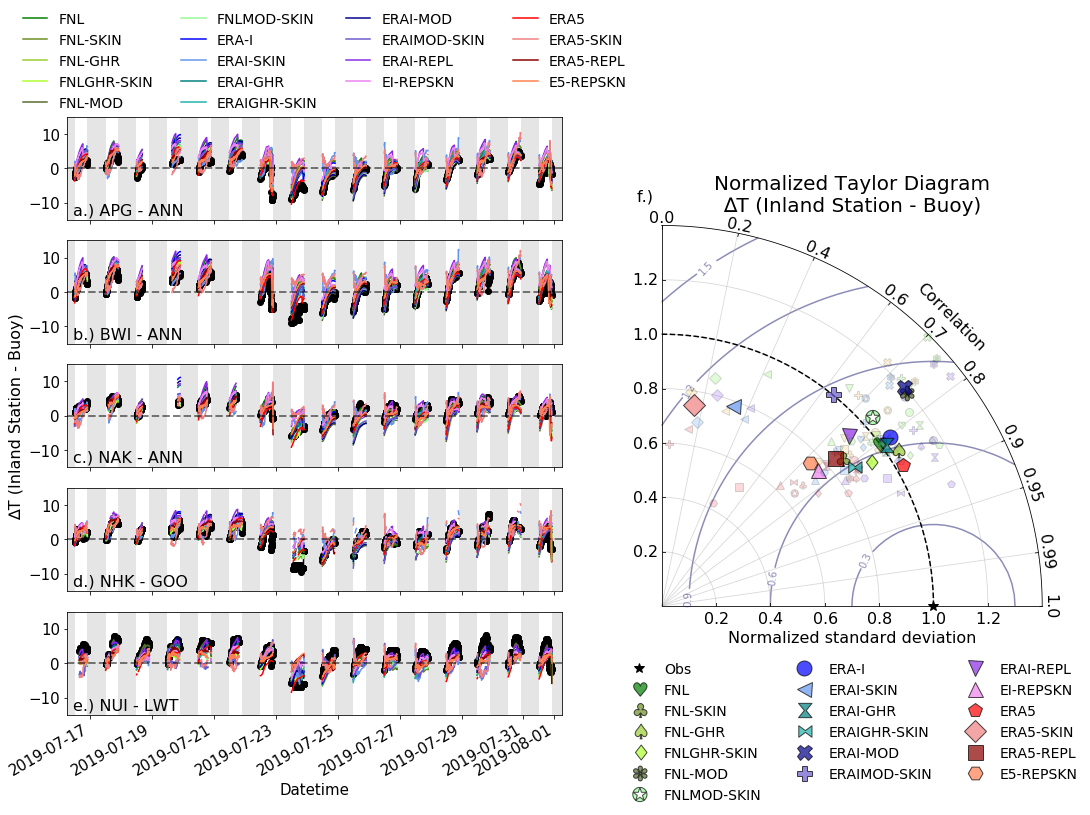

In [24]:
ymin,ymax = -15,15
ylabel = '∆T (Inland Station - Buoy)'


fig = plt.figure(figsize=(16,11.0))
plt.subplots_adjust(wspace=0.3)

gs1 = gridspec.GridSpec(len(TD_stns), 1)
gs1.update(left=0.05, right=0.48, wspace=0.05)
#ax1 = plt.subplot(gs1[0])
#ax2 = plt.subplot(gs1[1])
#ax3 = plt.subplot(gs1[2])
#ax4 = plt.subplot(gs1[3])

for ss,stn in enumerate(TD_stns):
    ax1 = plt.subplot(gs1[ss])

    obs = TD_obs_full[stn]['delT']

    ref_std = np.std(obs.dropna(how='any',dim='datetime').data)

    for cc,case in enumerate(cases_of_interest):
        case_plt_dict = case_dict[case]['d0{}'.format(doms_of_interest[cc])]
        sim = TD_wrf_twrs['{}_{}'.format(case,'d0{}'.format(doms_of_interest[cc]))][stn]['delT']

        if cc == 0:
            obs_plt = obs#.dropna(how='any',dim='datetime')
            if len(obs.dropna(how='any',dim='datetime')) > 2:
                obs_plt.plot(ax=ax1,c='k',marker='o')
        if len(sim.dropna(how='any',dim='datetime')) > 2:
            sim_plt = sim#.dropna(how='any',dim='datetime')
            sim_plt.plot(ax=ax1,label='{}'.format(case_plt_dict['name']),c=case_plt_dict['color'])
    ax1.set_title('')
    if ss == 2: ax1.set_ylabel(ylabel,size=16)
    if ss == 4:
        ax1.set_xlabel('Datetime',size=15)
        ax1.tick_params(labelsize=15)
    else:
        ax1.set_xlabel('')
        ax1.tick_params(labelbottom=False,labelsize=15)
    plt_start_date = pd.to_datetime(obs.datetime.values[0])
    plt_end_date = pd.to_datetime(obs.datetime.values[-1])
    for day in pd.date_range(start=plt_start_date - pd.to_timedelta(1,'d'), end=plt_end_date):
        night_s = pd.to_datetime('{0:04d}-{1:02d}-{2:02d} {3:02d}:00'.format(day.year,day.month,day.day,night_hour_s))
        night_e = pd.to_datetime('{0:04d}-{1:02d}-{2:02d} {3:02d}:00'.format(day.year,day.month,day.day,night_hour_e)) + pd.Timedelta(1,'d')
        ax1.fill_betweenx([-100,400],night_s,night_e,facecolor='k',alpha=0.1)   
    txt_y = txt_y = ymin + 0.02*(ymax-ymin)
    #if (stn == 'APG') or (stn == 'BWI'): txt_y = ymin + 0.80*(ymax-ymin)
    ax1.text(obs.datetime.data[60],txt_y,
             '{}.) {} - {}'.format(ascii_lowercase[ss],stn,closest_buoy_dict[stn]['buoy']),
             va='bottom',ha='left',size=16)
    ax1.set_ylim(ymin,ymax)
    ax1.set_xlim(sim.datetime.data[0],sim.datetime.data[-1])
    ax1.axhline(y=0.0,lw=2.0,alpha=0.5,c='k',ls='--')
    if ss == 0: ax1.legend(frameon=False,ncol=4,loc=(-0.1,1.01),fontsize=14,handlelength=1.75)


        
extend = False
TD_max_r = 1.4

dia = TaylorDiagram(1.0, fig=fig, 
                    extend=extend,
                    rect=122,
                    label='Obs',
                    normalize=True,
                    srange=[0.0,TD_max_r],
                    stdevticks=np.arange(0.2,5.6,0.2),
                    labelsize=16)
td_stats = {}

for cc,case in enumerate(cases_of_interest):
    case_plt_dict = case_dict[case]['d0{}'.format(doms_of_interest[cc])]
    td_stats[case] = pd.DataFrame(index=TD_stns, columns=['std_norm','R2'], dtype=float) 

    for ss,stn in enumerate(TD_stns):

        obs = TD_obs_full[stn]['delT']
        obs = obs.dropna(how='any',dim='datetime')
        sim = TD_wrf_twrs['{}_{}'.format(case,'d0{}'.format(doms_of_interest[cc]))][stn]['delT']
        sim = np.squeeze(sim.dropna(how='any',dim='datetime'))
        
        ref_std = np.std(obs.data)
        sim_std = np.std(sim.data)

        r2,_ = pearsonr(sim, obs)

        if ss == 0: 
            obs_full = obs - np.nanmean(obs)
            sim_full = sim - np.nanmean(sim)
            #label_str = '_'.join(case.replace('_KF','').split('_')[1:])
            label_str = None
        else:
            obs_full = np.concatenate([obs_full,obs - np.nanmean(obs)])
            sim_full = np.concatenate([sim_full,sim - np.nanmean(sim)])
            label_str = None
        #print(case,stn,np.std(sim.data)/ref_std)
        if case_plt_dict['fill']:
            marker_c = stn_colors[stn]
            marker_e = 'k'
        else:
            marker_c = stn_colors[stn]
            marker_e = stn_colors[stn]

        td_stats[case].loc[stn,'std_norm'] = sim_std/ref_std
        td_stats[case].loc[stn,'R2'] = r2

        dia.set_ref(ref_std)

        dia.add_sample(np.std(sim.data), r2,
                       marker=case_plt_dict['marker'], ms=8, ls='',
                       mfc=marker_c, mec=marker_e, # Colors
                       label=label_str,
                       zorder=cc,alpha=0.15)

            #if cc == 0:
            #    txt_x = 0.38 + 0.17*stn_count
            #    txt_y = 0.12
                #plt.text(txt_x,txt_y,'{0}'.format(stn),c=stn_colors[stn],size=22,ha='center')
                #plt.text(txt_x,txt_y-0.08,'{0:2.1f}'.format(ref_std),size=18,ha='center')
                #if ss == 0: plt.text(txt_x-0.1,txt_y-0.08,'ref. STD: ',size=18,ha='right')

    multimodal_mean = False

    if multimodal_mean:
        ref_std_full = np.std(obs_full)

        dia.add_sample(np.std(sim_full)/ref_std_full, np.corrcoef(sim_full,obs_full)[0,1],
               marker=case_plt_dict['marker'], ms=15, ls='',
               mfc=case_plt_dict['color'], mec='k', # Colors
               label=case_plt_dict['name'],
               zorder=cc+3,alpha=0.7)
    else:        
        td_stats[case]['angle'] = np.arccos(td_stats[case]['R2'])
        td_mean = td_stats[case].mean(axis=0)
        dia.add_sample(td_mean['std_norm'], np.cos(td_mean['angle']),
               norm=False, # don't normalize this point
               marker=case_plt_dict['marker'], ms=15, ls='',
               mfc=case_plt_dict['color'], mec='k', # Colors
               label=case_plt_dict['name'],
               zorder=cc+3,alpha=0.7)
contours = dia.add_contours(levels=5, colors='midnightblue',alpha=0.50,zorder=1)
dia.ax.clabel(contours, inline=1, fontsize=10, fmt='%.1f')
dia.add_grid(alpha=0.5)
plt.legend(frameon=False,fontsize=14,loc=(-0.1,-0.51),ncol=3)
plt.title('Normalized Taylor Diagram\n{}'.format(''.join(ylabel.split('\n')[0])),size=20,y=1.01)
plt.text(-0.03,1.49,'f.)',size=16,ha='right')
figname = '{}Inland_delT_TD'.format(save_dir)
if save_figs:
    plt.savefig('{}.png'.format(figname), bbox_inches = 'tight',pad_inches = 0.1)
    plt.savefig('{}.pdf'.format(figname), bbox_inches = 'tight',pad_inches = 0.1)
    print(figname)
plt.show()